# PART- 3 `( Handling Outliers )`

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
import re

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns', 1000)

# pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.rcParams["figure.figsize"] = (10,6)

In [2]:
df = pd.read_csv("filled_scout.csv")

In [3]:
df.shape

(15919, 27)

In [4]:
df.head().T

,0,1,2,3,4
make_model,Audi A1,Audi A1,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans,Sedans,Sedans
price,15770,14500,14640,14500,16790
vat,VAT deductible,Price negotiable,VAT deductible,VAT deductible,VAT deductible
km,56013.000,80000.000,83450.000,73000.000,16200.000
hp,66.000,141.000,85.000,66.000,66.000
type,Used,Used,Used,Used,Used
previous_owners,2.000,1.000,1.000,1.000,1.000
inspection_new,1,0,0,0,1
make,Audi,Audi,Audi,Audi,Audi


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15919 non-null  object 
 1   body_type            15919 non-null  object 
 2   price                15919 non-null  int64  
 3   vat                  15919 non-null  object 
 4   km                   15919 non-null  float64
 5   hp                   15919 non-null  float64
 6   type                 15919 non-null  object 
 7   previous_owners      15919 non-null  float64
 8   inspection_new       15919 non-null  int64  
 9   make                 15919 non-null  object 
 10  paint_type           15919 non-null  object 
 11  nr_of_doors          15919 non-null  float64
 12  nr_of_seats          15919 non-null  float64
 13  gearing_type         15919 non-null  object 
 14  displacement         15919 non-null  float64
 15  weight               15919 non-null 

<div class="alert alert-warning" role="alert">
 Functions to fill the missing values :
</div>

In [6]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [7]:
def fill_prop(df, group_col, col_name):
    '''Fills the missing values with "ffill and bfill method" according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

In [8]:
def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))

# Km

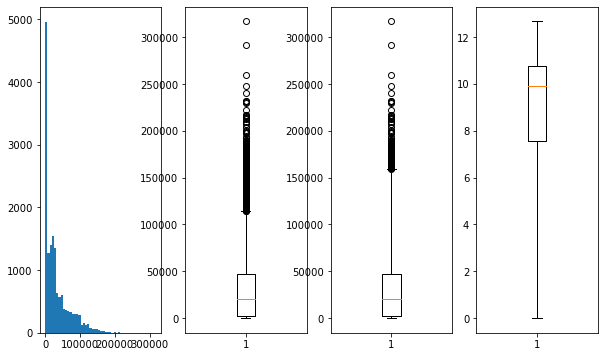

In [10]:
plt.subplot(141)
plt.hist(df.km, bins=50)

plt.subplot(142)
plt.boxplot(df.km)

plt.subplot(143)
plt.boxplot(df.km, whis=2.5)

plt.subplot(144)
plt.boxplot(np.log(df.km), whis = 2.5)
plt.show()


# Consumption_comb

In [11]:
df.cons_comb .describe()

count   15919.000
mean        4.831
std         0.869
min         3.000
25%         4.100
50%         4.800
75%         5.400
max         9.100
Name: cons_comb, dtype: float64

In [12]:
df.cons_comb.sort_values().head(10)

811     3.000
6173    3.000
3186    3.000
4281    3.000
10918   3.000
13947   3.000
13493   3.000
2620    3.000
13494   3.000
6319    3.000
Name: cons_comb, dtype: float64

In [13]:
df.cons_comb.sort_values().tail(10)

3649    8.300
3600    8.300
12553   8.600
12422   8.600
12530   8.600
10789   8.600
12054   8.700
12529   8.700
10817   8.700
10771   9.100
Name: cons_comb, dtype: float64

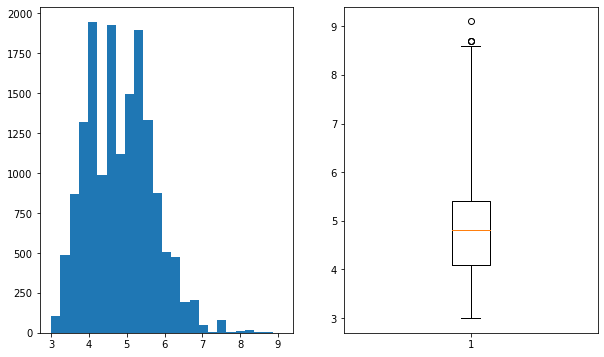

In [14]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(df.cons_comb, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_comb, whis = 2.5)

plt.show()

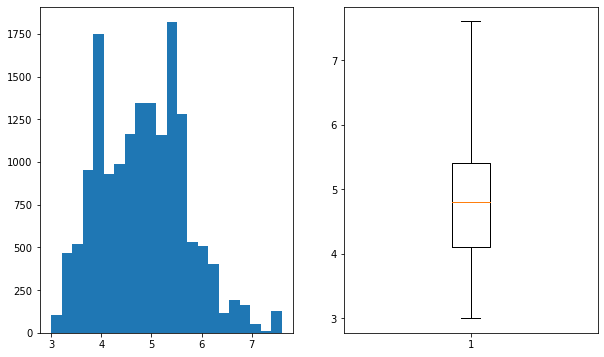

In [15]:
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.hist(winsorize(df.cons_comb, (0.003)), bins = 22)
# Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. 

plt.subplot(122)
plt.boxplot(winsorize(df.cons_comb, (0.003)), whis = 2)

plt.show()

# Displacement_cc

In [17]:
df.displacement.describe()

count   15919.000
mean     1425.609
std       329.720
min         1.000
25%      1229.000
50%      1461.000
75%      1598.000
max     16000.000
Name: displacement, dtype: float64

In [18]:
df.sort_values(by=["displacement"], ascending = False)["displacement"].head(50)

10932   16000.000
7169    15898.000
10771    2967.000
3595     2480.000
3587     2480.000
3649     2480.000
3590     2480.000
3599     2480.000
3598     2480.000
3596     2480.000
3600     2480.000
3601     2480.000
3610     2480.000
3609     2480.000
3608     2480.000
3606     2480.000
3605     2480.000
3648     2480.000
3592     2480.000
3593     2480.000
3602     2480.000
3604     2480.000
3603     2480.000
12176    2000.000
12462    2000.000
12521    2000.000
12170    2000.000
13027    2000.000
11929    2000.000
12179    2000.000
11935    2000.000
12181    2000.000
11800    2000.000
4188     2000.000
12526    2000.000
12959    2000.000
12527    2000.000
11977    2000.000
12469    2000.000
12520    2000.000
12464    2000.000
12265    2000.000
11870    2000.000
10556    2000.000
2903     2000.000
15197    2000.000
12414    2000.000
11988    2000.000
13050    2000.000
12412    2000.000
Name: displacement, dtype: float64

In [19]:
df.sort_values(by = ["displacement"], ascending = True)["displacement"].head(55)

12790     1.000
14319     1.000
14315     1.000
12849     1.000
12848     1.000
12835     1.000
12823     1.000
12815     1.000
12800     1.000
12798     1.000
12796     1.000
12786     1.000
12783     1.000
12781     1.000
12769     1.000
12768     1.000
12750     1.000
12670     1.000
12604     1.000
12554     1.000
12501     1.000
12499     1.000
12484     1.000
12473     1.000
12467     1.000
14284     1.000
14320     1.000
14321     1.000
14314     1.000
14322     1.000
14328     1.000
14327     1.000
13904     1.000
14325     1.000
14326     1.000
14324     1.000
10559     2.000
14198     2.000
13912    54.000
10194   122.000
7810    139.000
7812    139.000
7811    139.000
7809    139.000
8128    140.000
15578   160.000
15576   160.000
15574   160.000
15575   160.000
15577   160.000
15579   160.000
13653   890.000
14694   898.000
14342   898.000
14695   898.000
Name: displacement, dtype: float64

In [20]:
outlier_bool_list = df.displacement.isin([1, 2, 54, 122, 139, 140, 160, 16000, 15898])

In [21]:
outlier_bool_list

0        False
1        False
2        False
3        False
4        False
         ...  
15914    False
15915    False
15916    False
15917    False
15918    False
Name: displacement, Length: 15919, dtype: bool

In [22]:
df.loc[outlier_bool_list, "displacement"] = np.nan

In [23]:
fill(df, "make_model", "body_type", "displacement", "mode")

Number of NaN :  0
------------------
1598.000    5077
999.000     2467
1398.000    1388
1399.000     772
1461.000     682
1229.000     678
1956.000     670
1490.000     559
1422.000     467
1197.000     372
898.000      351
1395.000     320
1968.000     301
1149.000     288
1618.000     212
1798.000     210
1498.000     196
1600.000     130
1248.000     110
1997.000     103
1364.000     102
1400.000      90
998.000       72
1500.000      50
2000.000      46
1000.000      40
1998.000      25
2480.000      20
1984.000      18
1200.000      18
899.000       11
1397.000      11
1499.000       5
929.000        5
1596.000       4
900.000        4
997.000        4
1396.000       3
1199.000       3
1599.000       3
1589.000       2
995.000        2
1300.000       2
1495.000       2
1390.000       1
1696.000       1
1568.000       1
1368.000       1
890.000        1
1239.000       1
1496.000       1
973.000        1
996.000        1
1198.000       1
1333.000       1
1584.000       1
1686.000  

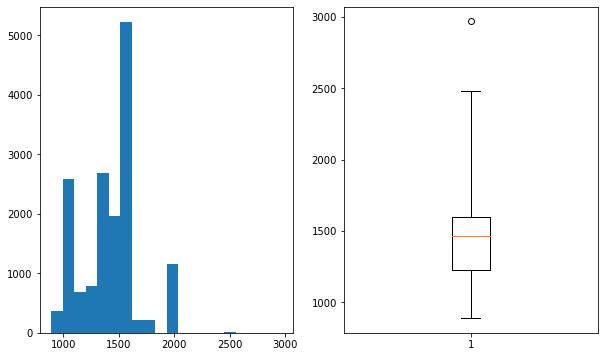

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.displacement, bins = 20)

plt.subplot(122)
plt.boxplot(df.displacement, whis = 2.5)

plt.show()

## Nr_of_Doors

In [28]:
df.nr_of_doors.value_counts(dropna=False)

5.000    11787
4.000     3079
3.000      832
2.000      219
7.000        1
1.000        1
Name: nr_of_doors, dtype: int64

In [29]:
df.nr_of_doors.replace([1,7], np.nan, inplace=True)

In [30]:
df.nr_of_doors.value_counts(dropna=False)

5.000    11787
4.000     3079
3.000      832
2.000      219
NaN          2
Name: nr_of_doors, dtype: int64

In [33]:
fill(df, "make_model", "body_type", "nr_of_doors", "mode")

Number of NaN :  0
------------------
5.000    11789
4.000     3079
3.000      832
2.000      219
Name: nr_of_doors, dtype: int64


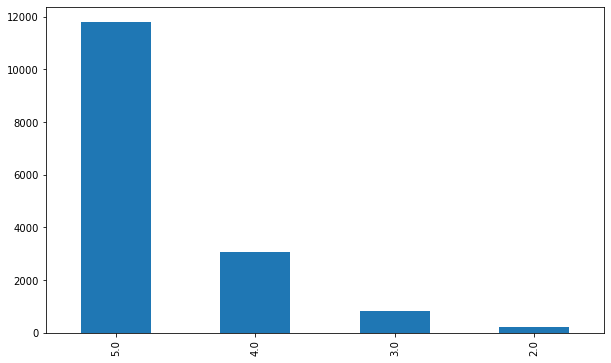

In [34]:
df.nr_of_doors.value_counts(dropna=False).plot.bar();

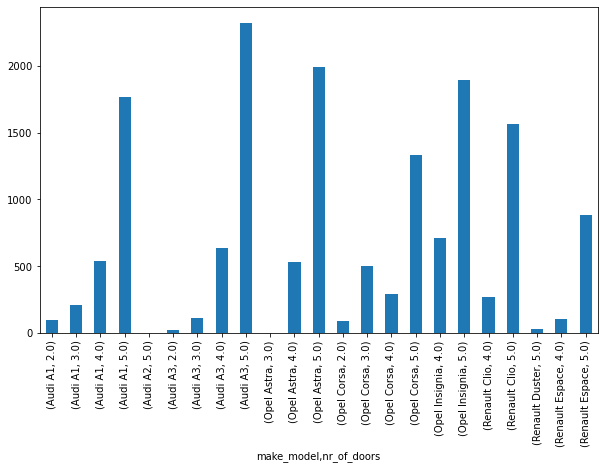

In [35]:
df.groupby(["make_model", "nr_of_doors"])["nr_of_doors"].count().plot.bar();

In [36]:
df.drop("nr_of_doors", axis=1, inplace=True)

# Nr_Of_Seats

In [38]:
df.nr_of_seats.value_counts(dropna = False )

5.000    14308
4.000     1127
7.000      362
2.000      119
6.000        2
3.000        1
Name: nr_of_seats, dtype: int64

In [39]:
df.nr_of_seats.replace([3,6],np.nan, inplace=True)

In [40]:
df.nr_of_seats.value_counts(dropna = False )

5.000    14308
4.000     1127
7.000      362
2.000      119
NaN          3
Name: nr_of_seats, dtype: int64

In [41]:
fill(df, "make_model", "body_type","nr_of_seats", "mode")

Number of NaN :  0
------------------
5.000    14311
4.000     1127
7.000      362
2.000      119
Name: nr_of_seats, dtype: int64


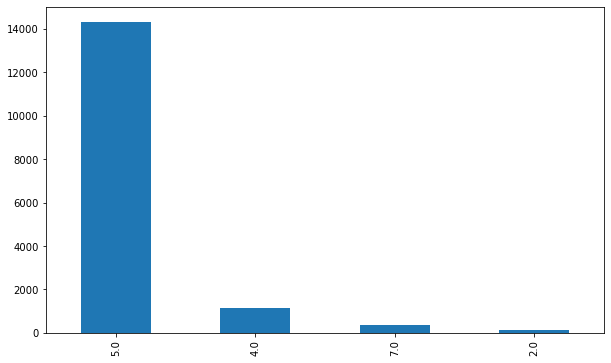

In [42]:
df.nr_of_seats.value_counts(dropna = False ).plot.bar();

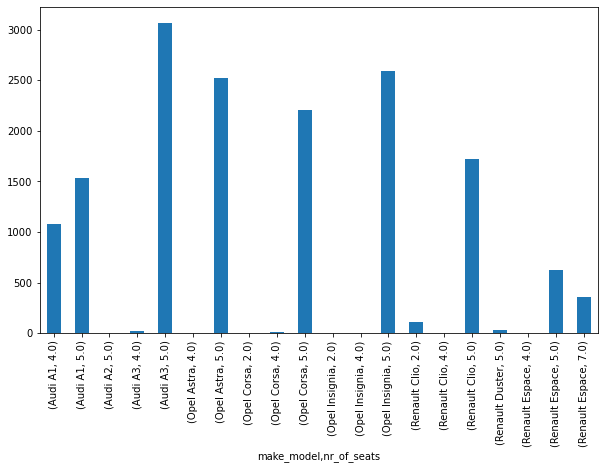

In [43]:
df.groupby(["make_model", "nr_of_seats"])["nr_of_seats"].count().plot.bar();

In [44]:
df.drop("nr_of_seats", axis=1, inplace=True)

# Weight

In [45]:
df.weight.describe()

count   15919.000
mean     1337.117
std       200.628
min         1.000
25%      1165.000
50%      1289.000
75%      1472.000
max      2471.000
Name: weight, dtype: float64

In [46]:
df["weight"].sort_values().head(10)

8355      1.000
12779     1.000
1143    102.000
8857    840.000
14313   900.000
13513   977.000
13555   977.000
14233   980.000
13935   980.000
13996   980.000
Name: weight, dtype: float64

In [47]:
df["weight"].replace([1, 102], np.nan, inplace = True)

In [48]:
df["weight"].isnull().sum()

3

In [49]:
fill(df, "make_model", "body_type", "weight","mode")

Number of NaN :  0
------------------
1163.000    1583
1360.000    1406
1487.000     958
1135.000     828
1425.000     731
1180.000     695
1273.000     656
1165.000     589
1503.000     570
1734.000     553
1087.000     291
1335.000     242
1365.000     211
1199.000     205
1350.000     156
1119.000     153
1355.000     136
1280.000     127
1260.000     127
1278.000     123
1275.000     112
1255.000     108
1200.000     107
1522.000     103
1659.000     102
1195.000      96
1120.000      93
1403.000      91
1701.000      87
1250.000      85
1685.000      83
1441.000      82
1308.000      80
1285.000      80
1090.000      77
1110.000      75
1613.000      75
1279.000      72
1364.000      70
1345.000      67
1733.000      65
1209.000      64
1141.000      64
1071.000      64
1325.000      64
1230.000      63
1205.000      59
1845.000      56
1052.000      53
1664.000      52
1154.000      52
1513.000      51
1065.000      50
1237.000      49
1088.000      46
1440.000      46
1265.000  

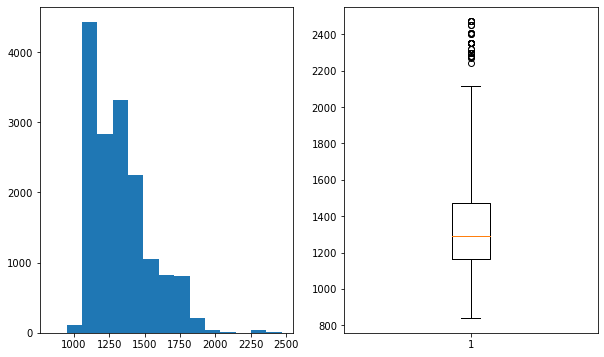

In [50]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.weight, bins=15)

plt.subplot(122)
plt.boxplot(df.weight, whis=2.5)

plt.show()

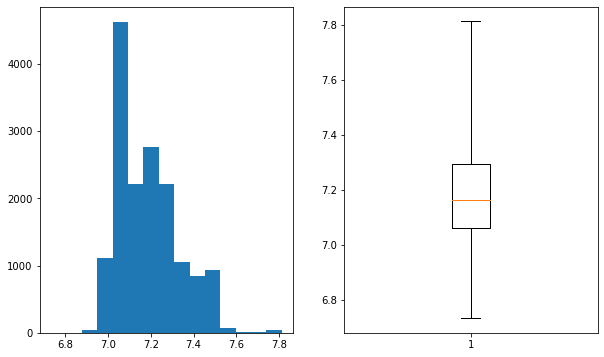

In [51]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.weight), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.weight), whis=2.5)

plt.show()

# hp

In [52]:
df.hp.describe()

count   15919.000
mean       88.372
std        26.840
min         1.000
25%        66.000
50%        85.000
75%       101.000
max       294.000
Name: hp, dtype: float64

In [53]:
df.hp.sort_values().head(50)

6034     1.000
7019     1.000
7014     1.000
9285     1.000
6005     1.000
9287     1.000
9288     1.000
7018     1.000
9289     1.000
9290     1.000
9292     1.000
9299     1.000
10610    1.000
10580    1.000
10579    1.000
10468    1.000
15155    1.000
15156    1.000
6946     1.000
7016     1.000
13885    4.000
3913     9.000
8857    40.000
13759   40.000
8408    44.000
10284   51.000
10285   51.000
10286   51.000
10287   51.000
9145    51.000
10288   51.000
10347   51.000
10346   51.000
10345   51.000
10283   51.000
10331   51.000
9025    51.000
10289   51.000
10290   51.000
10342   51.000
9159    51.000
9158    51.000
10291   51.000
10292   51.000
10294   51.000
9026    51.000
10282   51.000
10281   51.000
10280   51.000
10266   51.000
Name: hp, dtype: float64

In [54]:
df.hp.unique()

array([ 66., 141.,  85.,  70.,  92., 112.,  60.,  71.,  67., 110.,  93.,
       147.,  86., 140.,  87.,  81.,  82., 135., 132., 100.,  96., 162.,
       150., 294., 228., 270., 137.,   9., 133.,  77., 101.,  78., 103.,
         1.,  74., 118.,  84.,  88.,  80.,  76., 149.,  55.,  44.,  51.,
        52.,  63.,  40.,  65.,  75., 125., 120., 184., 239., 121., 143.,
       191.,  89., 195., 127., 122., 154., 155., 104., 123., 146.,  90.,
        56.,  53.,  54., 164.,   4., 163.,  57., 119., 165., 117., 115.,
        98., 168., 167.])

In [55]:
df.hp.loc[df.hp < 40] = np.nan

In [56]:
df.hp.isnull().sum()

22

In [57]:
fill(df, "make_model", "body_type", "hp", "mode")

Number of NaN :  0
------------------
85.000     2544
66.000     2124
81.000     1404
100.000    1312
110.000    1116
70.000      890
125.000     711
51.000      702
55.000      570
118.000     552
92.000      466
121.000     395
147.000     380
77.000      353
56.000      315
54.000      276
103.000     259
87.000      232
165.000     194
88.000      177
60.000      160
162.000      98
74.000       81
96.000       72
71.000       59
101.000      47
67.000       40
154.000      39
122.000      35
119.000      30
164.000      27
135.000      24
82.000       22
52.000       22
78.000       20
146.000      18
294.000      18
141.000      16
57.000       10
120.000       8
104.000       8
191.000       7
112.000       7
155.000       6
117.000       6
184.000       5
90.000        4
65.000        4
76.000        4
98.000        3
80.000        3
93.000        3
149.000       3
168.000       3
40.000        2
86.000        2
53.000        2
228.000       2
167.000       2
143.000       2
15

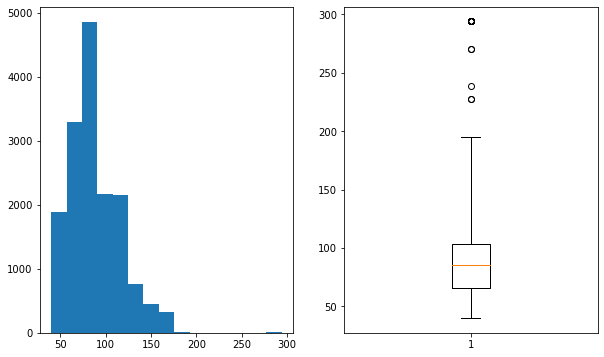

In [58]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df.hp, bins=15)

plt.subplot(122)
plt.boxplot(df.hp, whis=2.5)

plt.show()

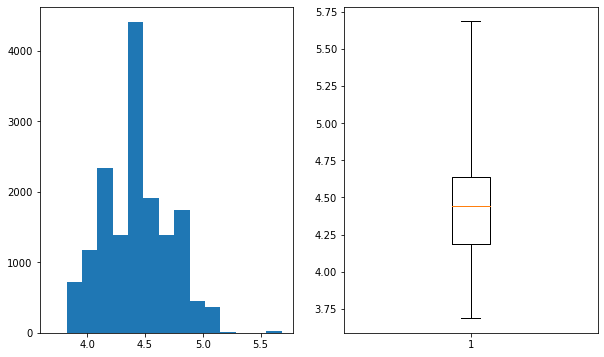

In [59]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(np.log(df.hp), bins=15)

plt.subplot(122)
plt.boxplot(np.log(df.hp), whis=2.5)

plt.show()

# price

In [60]:
df.price.describe()

count   15919.000
mean    18019.897
std      7386.169
min        13.000
25%     12850.000
50%     16900.000
75%     21900.000
max     74600.000
Name: price, dtype: float64

In [61]:
df.price.sort_values().head(5)

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [62]:
df.drop(index = [8594, 8828, 6066,8829], axis = 0, inplace = True)

In [63]:
df.shape

(15915, 25)

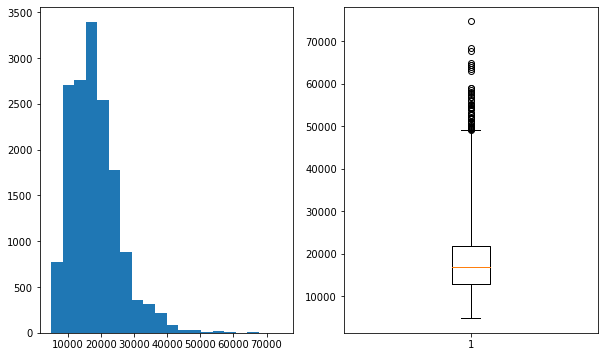

In [64]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

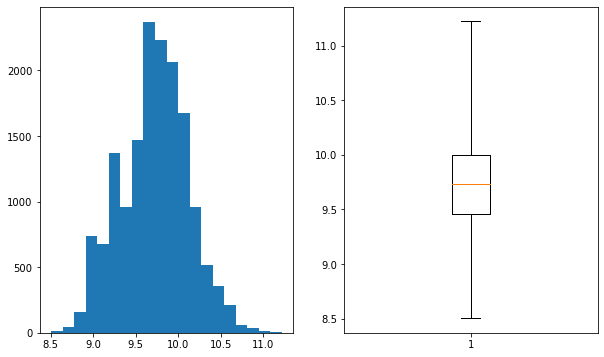

In [65]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist(np.log(df.price), bins=20)

plt.subplot(122)
plt.boxplot(np.log(df.price), whis=2.3)

plt.show()

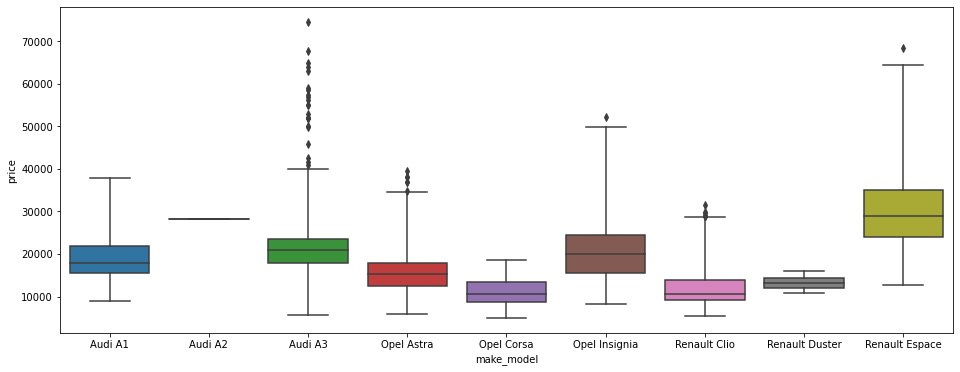

In [66]:
plt.figure(figsize=(16,6))
sns.boxplot(x="make_model", y="price", data=df, whis=3)
plt.show()

# Final_Step

In [67]:
df.head().T

,0,1,2,3,4
make_model,Audi A1,Audi A1,Audi A1,Audi A1,Audi A1
body_type,Sedans,Sedans,Sedans,Sedans,Sedans
price,15770,14500,14640,14500,16790
vat,VAT deductible,Price negotiable,VAT deductible,VAT deductible,VAT deductible
km,56013.000,80000.000,83450.000,73000.000,16200.000
hp,66.000,141.000,85.000,66.000,66.000
type,Used,Used,Used,Used,Used
previous_owners,2.000,1.000,1.000,1.000,1.000
inspection_new,1,0,0,0,1
make,Audi,Audi,Audi,Audi,Audi


In [69]:
numeric_col = "price,km,gears,previous_owners,cons_comb,displacement,age,hp,weight".split(",")

In [70]:
df_num = df[numeric_col]

In [71]:
df_num

,price,km,gears,previous_owners,cons_comb,displacement,age,hp,weight
0,15770,56013.000,7.000,2.000,3.800,1422.000,3.000,66.000,1220.000
1,14500,80000.000,7.000,1.000,5.600,1798.000,2.000,141.000,1255.000
2,14640,83450.000,7.000,1.000,3.800,1598.000,3.000,85.000,1135.000
3,14500,73000.000,6.000,1.000,3.800,1422.000,3.000,66.000,1195.000
4,16790,16200.000,7.000,1.000,4.100,1422.000,3.000,66.000,1135.000
...,...,...,...,...,...,...,...,...,...
15914,39950,1647.363,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000
15915,39885,9900.000,7.000,1.000,7.400,1798.000,0.000,165.000,1708.000
15916,39875,15.000,6.000,1.000,5.300,1997.000,0.000,146.000,1734.000
15917,39700,10.000,6.000,1.000,5.300,1997.000,0.000,147.000,1758.000


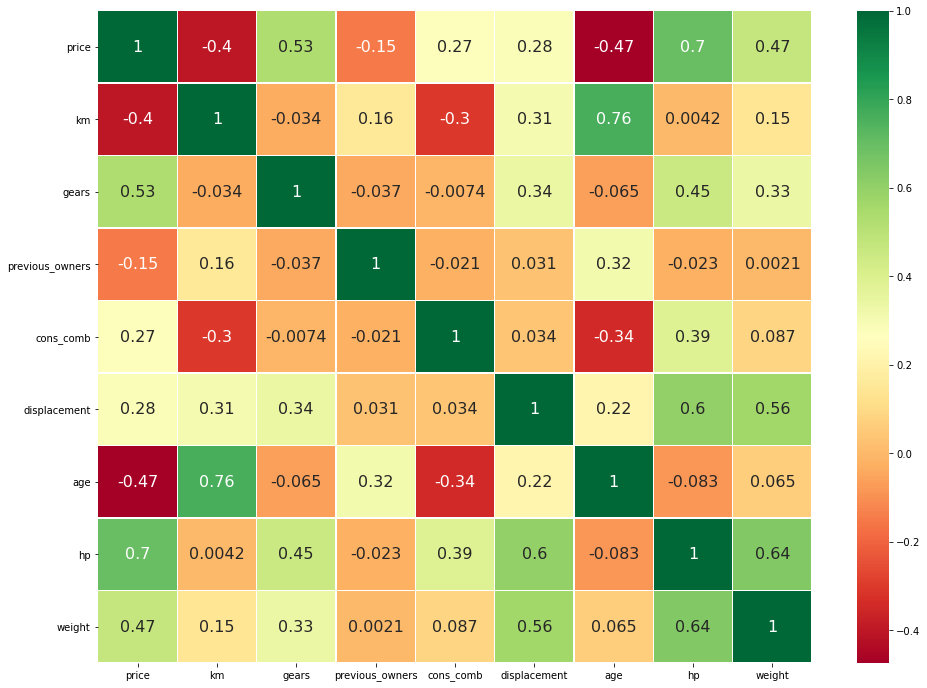

In [72]:
plt.figure(figsize = (16,12))
sns.heatmap(df_num.corr(), annot = True, cmap="RdYlGn", linewidths=0.2, annot_kws = {"size": 16});

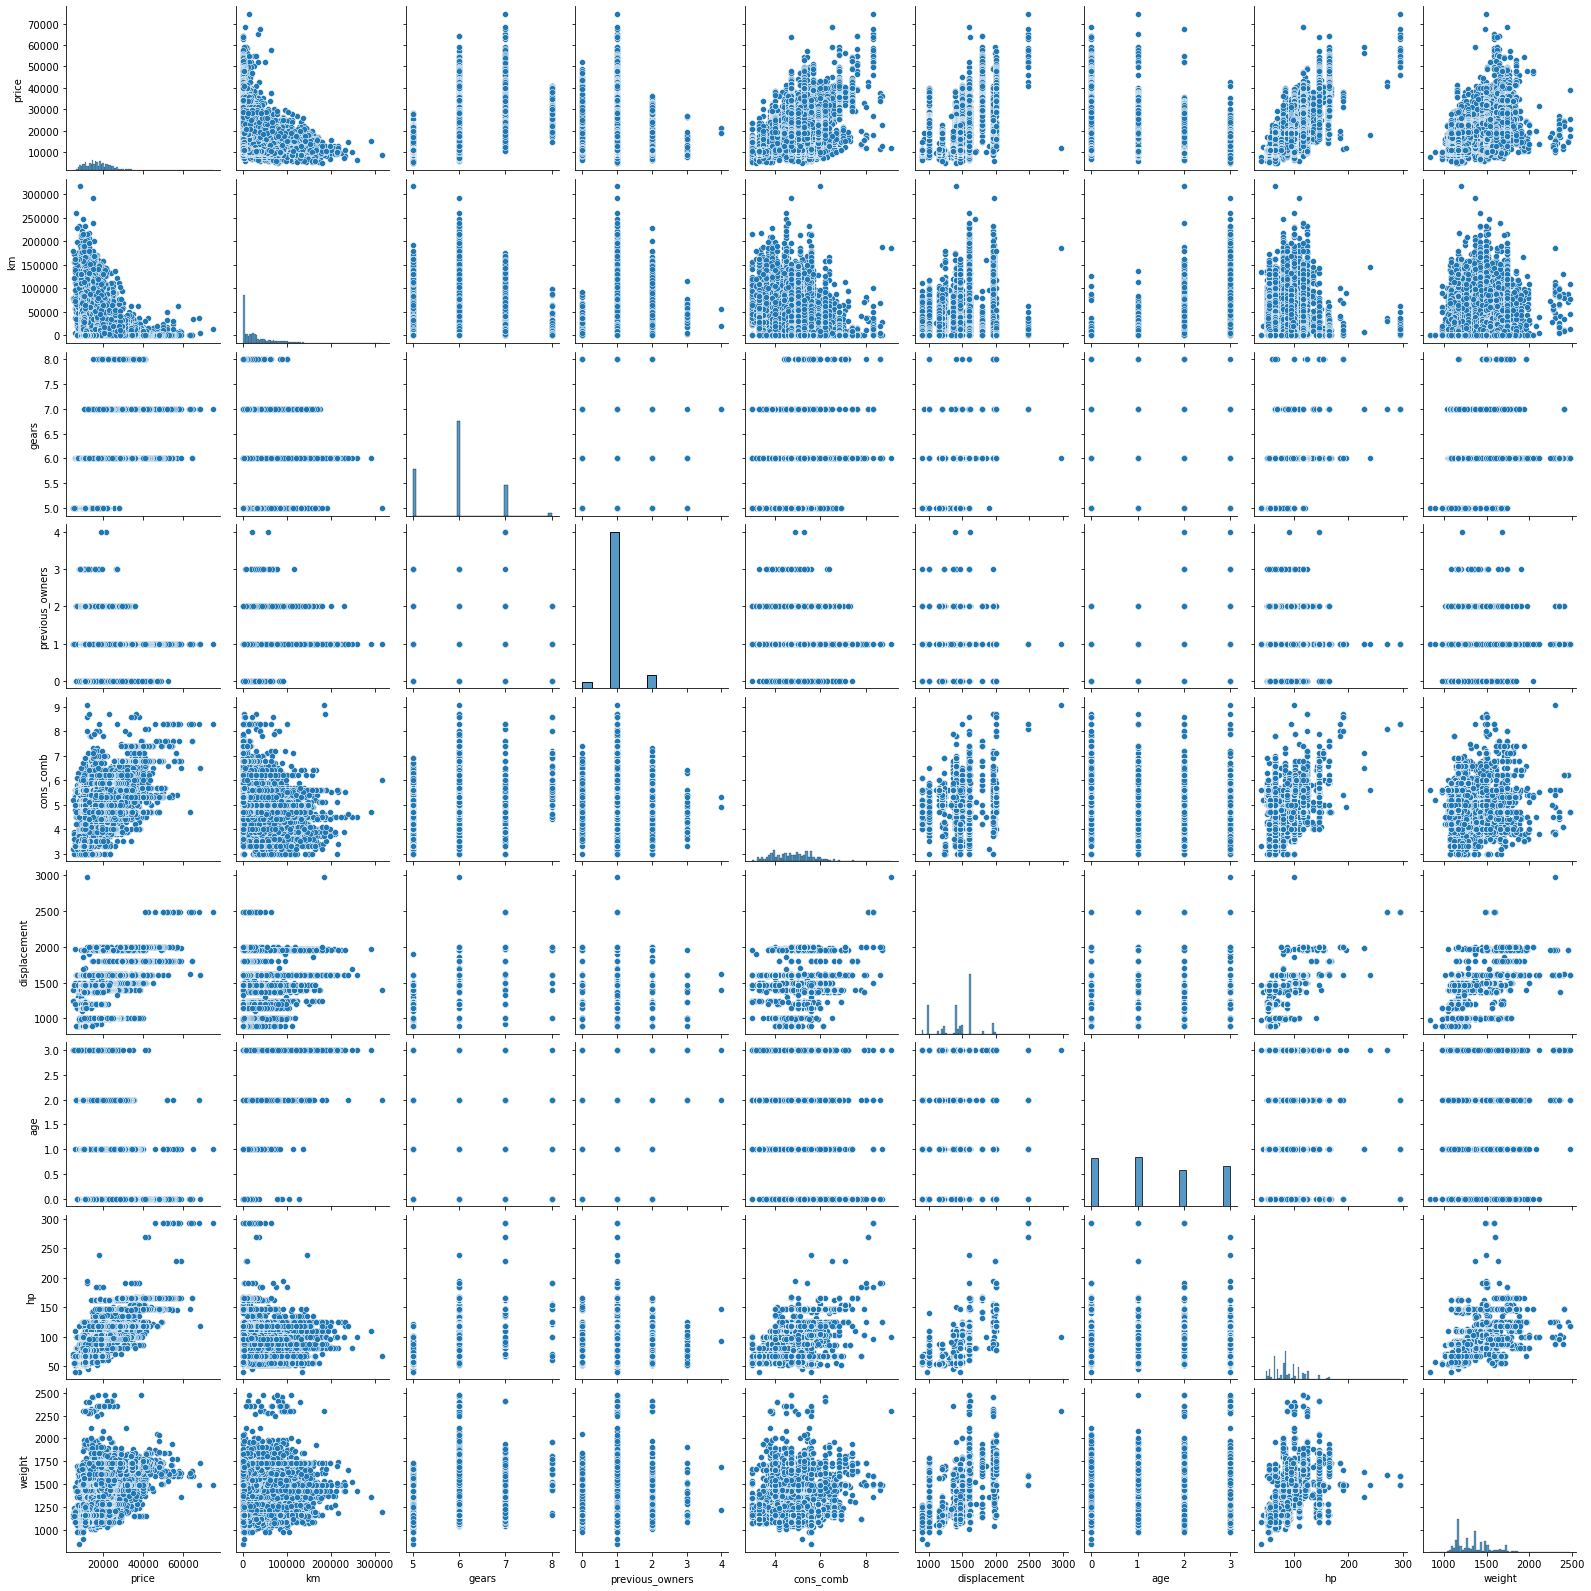

In [73]:
sns.pairplot(df_num, size = 2.5)
plt.show()

# Dummy Operation

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15915 entries, 0 to 15918
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15915 non-null  object 
 1   body_type            15915 non-null  object 
 2   price                15915 non-null  int64  
 3   vat                  15915 non-null  object 
 4   km                   15915 non-null  float64
 5   hp                   15915 non-null  float64
 6   type                 15915 non-null  object 
 7   previous_owners      15915 non-null  float64
 8   inspection_new       15915 non-null  int64  
 9   make                 15915 non-null  object 
 10  paint_type           15915 non-null  object 
 11  gearing_type         15915 non-null  object 
 12  displacement         15915 non-null  float64
 13  weight               15915 non-null  float64
 14  drive_chain          15915 non-null  object 
 15  fuel                 15915 non-null 

In [75]:
df.shape

(15915, 25)

In [76]:
df.to_csv("final_scout_not_dummy.csv", index=False)

In [78]:
df[["comfort_convenience", "entertainment_media", "extras", "safety_security"]]

,comfort_convenience,entertainment_media,extras,safety_security
0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...","Alloy wheels,Catalytic Converter,Voice Control","ABS,Central door lock,Daytime running lights,D..."
1,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...","Alloy wheels,Sport seats,Sport suspension,Voic...","ABS,Central door lock,Central door lock with r..."
2,"Air conditioning,Cruise control,Electrical sid...","MP3,On-board computer","Alloy wheels,Voice Control","ABS,Central door lock,Daytime running lights,D..."
3,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,CD player,Hands-free equipment,MP3,O...","Alloy wheels,Sport seats,Voice Control","ABS,Alarm system,Central door lock with remote..."
4,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...","Alloy wheels,Sport package,Sport suspension,Vo...","ABS,Central door lock,Driver-side airbag,Elect..."
...,...,...,...,...
15914,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Hands-free equipment,O...","Alloy wheels,Touch screen","ABS,Central door lock,Central door lock with r..."
15915,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Hands-free equipment,R...","Alloy wheels,Touch screen,Voice Control","ABS,Adaptive Cruise Control,Blind spot monitor..."
15916,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",Alloy wheels,"ABS,Adaptive Cruise Control,Blind spot monitor..."
15917,"Air conditioning,Automatic climate control,Cru...","Bluetooth,Digital radio,Radio,USB","Alloy wheels,Touch screen","ABS,Blind spot monitor,Driver-side airbag,Elec..."


In [79]:
# STR + GET_DUMMIES

df = df.join(df["comfort_convenience"].str.get_dummies(sep = ",").add_prefix("cc_"))
df = df.join(df["entertainment_media"].str.get_dummies(sep = ",").add_prefix("em_"))
df = df.join(df["extras"].str.get_dummies(sep = ",").add_prefix("ex_"))
df = df.join(df["safety_security"].str.get_dummies(sep = ",").add_prefix("ss_"))

In [80]:
df.drop(["comfort_convenience", "entertainment_media", "extras", "safety_security"], axis=1, inplace=True)

In [81]:
df.shape

(15915, 115)

In [82]:
df.drop("make", axis=1, inplace=True)

In [83]:
df.country_version.value_counts(dropna=False)

Germany           8792
Italy             2798
Netherlands        929
Spain              867
European Union     833
Belgium            816
Austria            434
France             100
Czech Republic      90
Poland              82
Denmark             58
Hungary             47
Japan               31
Serbia               8
Croatia              7
Slovakia             6
Bulgaria             4
Switzerland          4
Romania              3
Sweden               3
Egypt                1
Luxembourg           1
Slovenia             1
Name: country_version, dtype: int64

In [84]:
df.drop("country_version", axis=1, inplace=True)

In [85]:
df.shape

(15915, 113)

In [86]:
df_final = pd.get_dummies(df)

In [87]:
df_final.shape

(15915, 151)

In [88]:
len(df_final.columns)

151

In [89]:
df_final.head().T

,0,1,2,3,4
price,15770.000,14500.000,14640.000,14500.000,16790.000
km,56013.000,80000.000,83450.000,73000.000,16200.000
hp,66.000,141.000,85.000,66.000,66.000
previous_owners,2.000,1.000,1.000,1.000,1.000
inspection_new,1.000,0.000,0.000,0.000,1.000
displacement,1422.000,1798.000,1598.000,1422.000,1422.000
weight,1220.000,1255.000,1135.000,1195.000,1135.000
gears,7.000,7.000,7.000,6.000,7.000
age,3.000,2.000,3.000,3.000,3.000
cons_comb,3.800,5.600,3.800,3.800,4.100


In [90]:
df_final.to_csv("final_scout_dummy.csv", index=False)